# Spatial profiles along slit from FORS1 spectra

I would like to achieve the following:

1. [X] Identify W 3 and the bow shock in the spectra
2. [X] Trace the full western extent of the bow shock in [Ar IV]
    - the MUSE field extends only 22 arcsec from the star
    - the FORS1 spectrum shows a roughly linear ramp that extends about 34 arcsec (see image below)
3. [X] Calculate the [O III] 4363/5007 temperature profile of the bow shock
    - See if there is any evidence for temperatures as high as the [Ar IV] temperature
4. [X] Measure the [Ne III] 3869 profile.  Ne$^+$ has the same ionization potential as Ar$^{+2}$ (40 eV), but [Ne III] seems to be much more broadly distributed than [Ar IV]



![FORS1 profile of Ar IV](assets/ngc346-screenshot-fors1-ariv-profile.png)



In [1]:
from pathlib import Path
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import regions
from astropy.io import fits
from astropy.wcs import WCS
import sys

sys.path.append("../lib")
import extract

sns.set_context("talk")
sns.set_color_codes()

Load line and continuum images for the two blue spectral ranges.  We may use the continuum for masking out regions that have excessive stellar contamination.

In [2]:
hdu1 = fits.open("../data/ngc346-fors1-A-3500-4600-contsub.fits")[0]
hdu2 = fits.open("../data/ngc346-fors1-A-4400-6000-contsub.fits")[0]
hdu1c = fits.open("../data/ngc346-fors1-A-3500-4600-cont.fits")[0]
hdu2c = fits.open("../data/ngc346-fors1-A-4400-6000-cont.fits")[0]

In [3]:
hdu1B = fits.open("../data/ngc346-fors1-B-3562-4600-contsub.fits")[0]
hdu2B = fits.open("../data/ngc346-fors1-B-4400-6000-contsub.fits")[0]
hdu1cB = fits.open("../data/ngc346-fors1-B-3562-4600-cont.fits")[0]
hdu2cB = fits.open("../data/ngc346-fors1-B-4400-6000-cont.fits")[0]

Set up the world coords for the two ranges

In [4]:
wcs1 = WCS(hdu1)
wcs2 = WCS(hdu2)
wcs1B = WCS(hdu1B)
wcs2B = WCS(hdu2B)
for w in wcs1, wcs2, wcs1B, wcs2B:
    w.wcs.cdelt[1] *= -1.0

Set up the lines that we want with wavelength limits:

In [5]:
pv1A = extract.PositionVelocityImage(hdu1.data, wcs1)
pv2A = extract.PositionVelocityImage(hdu2.data, wcs2)
pvc1A = extract.PositionVelocityImage(hdu1c.data, wcs1)
pvc2A = extract.PositionVelocityImage(hdu2c.data, wcs2)
pv1B = extract.PositionVelocityImage(hdu1B.data, wcs1B)
pv2B = extract.PositionVelocityImage(hdu2B.data, wcs2B)
pvc1B = extract.PositionVelocityImage(hdu1cB.data, wcs1B)
pvc2B = extract.PositionVelocityImage(hdu2cB.data, wcs2B)

In [6]:
restwav = {
    "He II 4686": 4685.68,
    "[Ar IV] 4740": 4740.17,
    "[O III] 5007": 5006.84,
    "[O III] 4363": 4363.209,
    "[Ne III] 3869": 3869.07,
    "H I 4861": 4861.32,
    "H I 4340": 4340.463,
    "H I 4102": 4101.735,
    "He I 5876": 5875.62,
    "[Cl III] 5518": 5517.71,
    "[Cl III] 5538": 5537.88,
    "[N II] 5755": 5755.08,
    "[Fe III] 4658": 4658.10,
    "[Fe III] 4987": 4987.20,
    "[Fe III] 5270": 5270.4,
    "O II 4650": 4650.00,
    "[O II] 3729": 3728.815,
    "[O II] 3726": 3726.032,
    "Wing 4975": 4975.0,
}

In [7]:
emlines = {k: extract.EmissionLine(k, v, vlim=(100.0, 400.0)) for k, v in restwav.items()}

In [8]:
emlines

{'He II 4686': EmissionLine(name='He II 4686', wav0=4685.68, vlim=(100.0, 400.0)),
 '[Ar IV] 4740': EmissionLine(name='[Ar IV] 4740', wav0=4740.17, vlim=(100.0, 400.0)),
 '[O III] 5007': EmissionLine(name='[O III] 5007', wav0=5006.84, vlim=(100.0, 400.0)),
 '[O III] 4363': EmissionLine(name='[O III] 4363', wav0=4363.209, vlim=(100.0, 400.0)),
 '[Ne III] 3869': EmissionLine(name='[Ne III] 3869', wav0=3869.07, vlim=(100.0, 400.0)),
 'H I 4861': EmissionLine(name='H I 4861', wav0=4861.32, vlim=(100.0, 400.0)),
 'H I 4340': EmissionLine(name='H I 4340', wav0=4340.463, vlim=(100.0, 400.0)),
 'H I 4102': EmissionLine(name='H I 4102', wav0=4101.735, vlim=(100.0, 400.0)),
 'He I 5876': EmissionLine(name='He I 5876', wav0=5875.62, vlim=(100.0, 400.0)),
 '[Cl III] 5518': EmissionLine(name='[Cl III] 5518', wav0=5517.71, vlim=(100.0, 400.0)),
 '[Cl III] 5538': EmissionLine(name='[Cl III] 5538', wav0=5537.88, vlim=(100.0, 400.0)),
 '[N II] 5755': EmissionLine(name='[N II] 5755', wav0=5755.08, vlim=

In [9]:
for em in emlines.values():
    if em.wav0 > 4400:
        em.pvA = pv2A
        em.pvB = pv2B
        em.pvcA = pvc2A
        em.pvcB = pvc2B
    else:
        em.pvA = pv1A
        em.pvB = pv1B
        em.pvcA = pvc1A
        em.pvcB = pvc1B

In [10]:
for em in emlines.values():
    em.A = em.pvA.slit_profile(em)
    em.ewA = em.pvA.slit_ew_profile(em, em.pvcA)
    em.cA = em.pvcA.slit_profile(em)
    em.B = em.pvB.slit_profile(em)
    em.ewB = em.pvB.slit_ew_profile(em, em.pvcB)
    em.cB = em.pvcB.slit_profile(em)

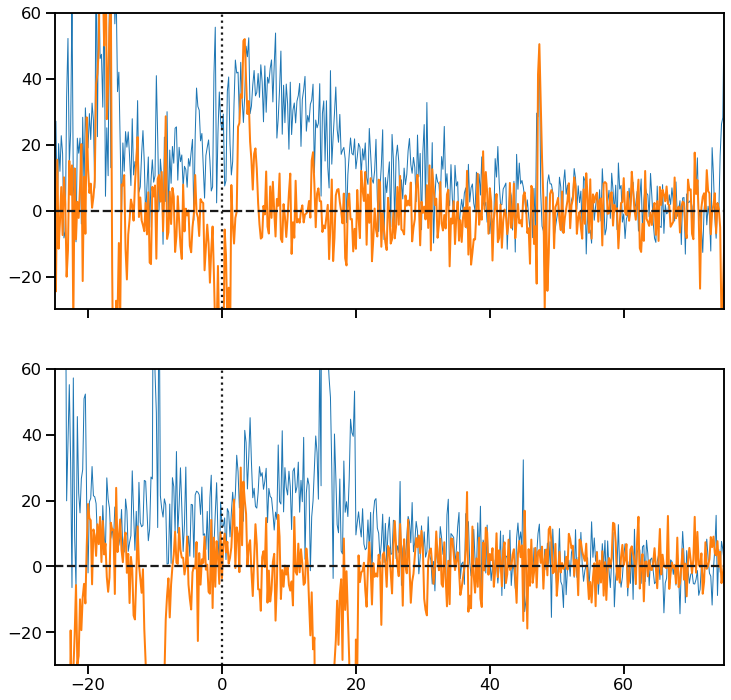

In [11]:
fig, axes = plt.subplots(
    2,
    1,
    figsize=(12, 12),
    sharex=True,
)
e = emlines["[Ar IV] 4740"]
axes[0].plot(e.A.position, e.A.data, linewidth=1.0, alpha=1.0)
axes[1].plot(e.B.position, e.B.data, linewidth=1.0, alpha=1.0)

e = emlines["He II 4686"]
axes[0].plot(e.A.position, e.A.data, linewidth=2.0, alpha=1.0)
axes[1].plot(e.B.position, e.B.data, linewidth=2.0, alpha=1.0)

axes[0].axhline(0.0, linestyle="dashed", color="k")
axes[0].axvline(0.0, linestyle="dotted", color="k")

axes[1].axhline(0.0, linestyle="dashed", color="k")
axes[1].axvline(0.0, linestyle="dotted", color="k")

for ax in axes:
    ax.set(
        xlim=[-25, 75],
        ylim=[-30, 60],
    )

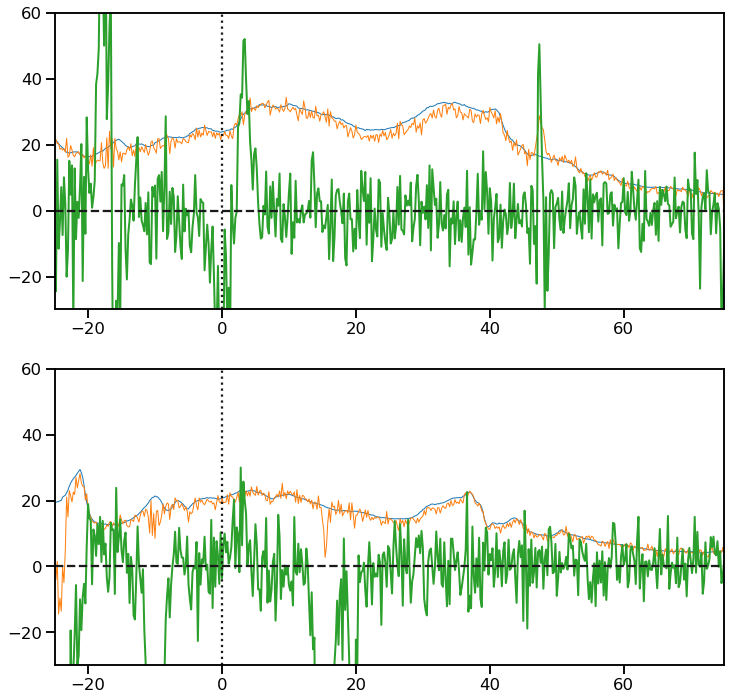

In [12]:
fig, axes = plt.subplots(2, 1, figsize=(12, 12))
e = emlines["[O III] 5007"]
axes[0].plot(e.A.position, 1e-3 * e.A.data, linewidth=1.0, alpha=1.0)
axes[1].plot(e.B.position, 1e-3 * e.B.data, linewidth=1.0, alpha=1.0)

e = emlines["[O III] 4363"]
axes[0].plot(e.A.position, 0.075 * e.A.data, linewidth=1.0, alpha=1.0)
axes[1].plot(e.B.position, 0.075 * e.B.data, linewidth=1.0, alpha=1.0)

e = emlines["He II 4686"]
axes[0].plot(e.A.position, e.A.data, linewidth=2.0, alpha=1.0)
axes[1].plot(e.B.position, e.B.data, linewidth=2.0, alpha=1.0)

for ax in axes:
    ax.axhline(0.0, linestyle="dashed", color="k")
    ax.axvline(0.0, linestyle="dotted", color="k")
    ax.set(
        xlim=[-25, 75],
        ylim=[-30, 60],
    )

In [13]:
Amask = emlines["[O III] 5007"].ewA.data > 250.0
Bmask = emlines["[O III] 5007"].ewB.data > 250.0

for e in emlines.values():
    e.multiA = e.A.multibin(kmax=10, mask=Amask)
    e.multiB = e.B.multibin(kmax=10, mask=Bmask)
    e.multi_cA = e.cA.multibin()
    e.multi_cB = e.cB.multibin()    

../lib/tetrabloks/rebin_utils.py:56: RuntimeWarning: invalid value encountered in true_divide
  (profile[e] * mask[e] * weights[e] + profile[o] * mask[o] * weights[o])


oversample: nan(s) found in input profile
oversample: nan(s) found in output profile
oversample: nan(s) found in input profile
oversample: nan(s) found in output profile
oversample: nan(s) found in input profile
oversample: nan(s) found in output profile
oversample: nan(s) found in input profile
oversample: nan(s) found in output profile
oversample: nan(s) found in input profile
oversample: nan(s) found in output profile
oversample: nan(s) found in input profile
oversample: nan(s) found in output profile
oversample: nan(s) found in input profile
oversample: nan(s) found in output profile
oversample: nan(s) found in input profile
oversample: nan(s) found in output profile
oversample: nan(s) found in input profile
oversample: nan(s) found in output profile
oversample: nan(s) found in input profile
oversample: nan(s) found in output profile
oversample: nan(s) found in input profile
oversample: nan(s) found in output profile
oversample: nan(s) found in input profile
oversample: nan(s) foun

In [14]:
e.multiB[512].data

array([nan, nan, nan, ..., nan, nan, nan])

Reddening correction for 4363 / 5007 from Mabel paper:

In [15]:
redcorr_oiii_ratio = (7.06 / 522.70) / (6.82 / 534.12)
average_ratio_mabel = (7.06 / 522.70)
redcorr_oiii_ratio, average_ratio_mabel

(1.0578075602261434, 0.013506791658695234)

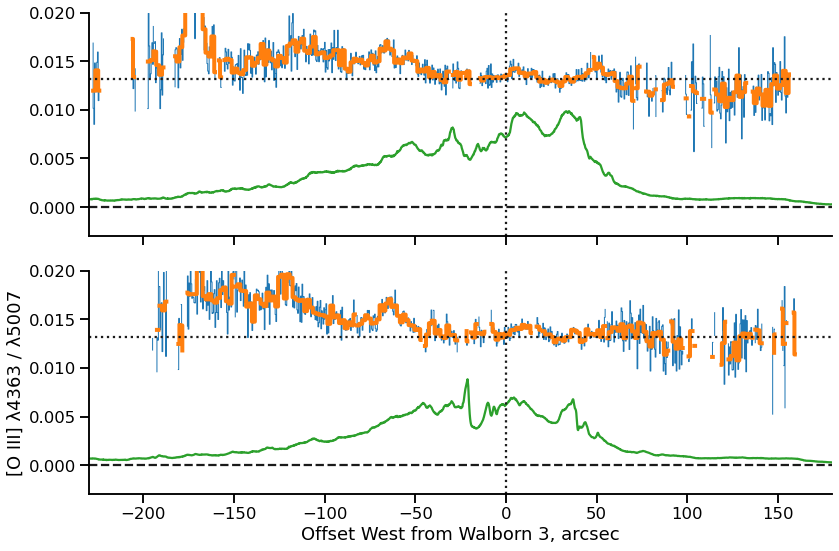

In [16]:
fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True, sharey=True)
e1 = emlines["[O III] 4363"]
e2 = emlines["[O III] 5007"]
# min, xmax = -10, 50
xmin, xmax = -230, 180

n = 2
ratioA = redcorr_oiii_ratio * e1.multiA[n].data / e2.multiA[n].data
ratioB = redcorr_oiii_ratio * e1.multiB[n].data / e2.multiB[n].data
posA = e1.multiA[n].position
posB = e1.multiB[n].position
axes[0].plot(posA, ratioA, linewidth=1.0, alpha=1.0, drawstyle="steps-mid")
axes[1].plot(posB, ratioB, linewidth=1.0, alpha=1.0, drawstyle="steps-mid")

n = 8
ratioA = redcorr_oiii_ratio * e1.multiA[n].data / e2.multiA[n].data
ratioB = redcorr_oiii_ratio * e1.multiB[n].data / e2.multiB[n].data
posA = e1.multiA[n].position
posB = e1.multiB[n].position
axes[0].plot(posA, ratioA, linewidth=4.0, alpha=1.0, drawstyle="steps-mid")
axes[1].plot(posB, ratioB, linewidth=4.0, alpha=1.0, drawstyle="steps-mid")

axes[0].plot(e2.A.position, 3e-7 * e2.A.data)
axes[1].plot(e2.B.position, 3e-7 * e2.B.data)

# axes[0].plot(e1.cA.position, 5e-7*e1.cA.data)
# axes[1].plot(e1.cB.position, 5e-7*e1.cB.data)

m = (posA > -50) & (posA < xmax)
average_ratioA = np.nanmean(ratioA[m])
m = (posB > -50) & (posB < xmax)
average_ratioB = np.nanmean(ratioB[m])

average_ratio = np.mean([average_ratioA, average_ratioB])

for ax, ratio in zip(axes, [ratioA, ratioB]):
    ax.axhline(0.0, linestyle="dashed", color="k")
    ax.axhline(
        average_ratio,
        linestyle="dotted",
        color="k",
    )
    ax.axvline(0.0, linestyle="dotted", color="k")
    ax.set(
        xlim=[xmin, xmax],
        ylim=[-0.003, 0.02],
    )
axes[-1].set(
    xlabel="Offset West from Walborn 3, arcsec",
    ylabel="[O III] λ4363 / λ5007",
)
sns.despine()
fig.tight_layout()
fig.savefig("../figs/ngc346-fors1-oiii-4363-5007-ratio.pdf")

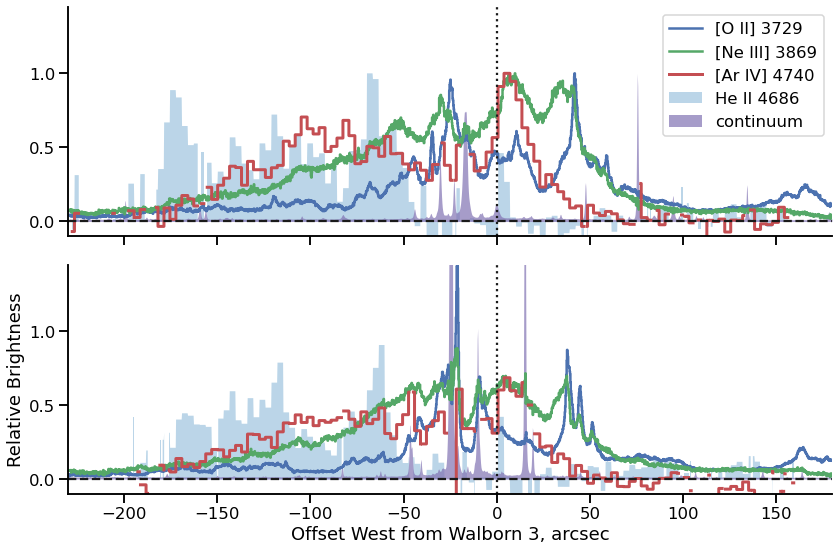

In [17]:
fig, axes = plt.subplots(
    2,
    1,
    figsize=(12, 8),
    sharex=True,
    sharey=True,
)
n = 16

e = emlines["He II 4686"]
fac = 1.0 / np.nanmax(e.multiA[n].data)
axes[0].fill_between(
    e.multiA[n].position,
    fac * e.multiA[n].data,
    linewidth=2.0,
    alpha=0.3,
    label=e.name,
)
axes[1].fill_between(
    e.multiB[n].position,
    fac * e.multiB[n].data,
    linewidth=2.0,
    alpha=0.3,
)

e = emlines["[O II] 3729"]
fac = 1.0 / np.nanmax(e.A.data)
axes[0].plot(
    e.A.position,
    fac * e.A.data,
    linewidth=2.5,
    alpha=1.0,
    drawstyle="steps-mid",
    color="b",
    label=e.name,
)
axes[1].plot(
    e.B.position,
    fac * e.B.data,
    linewidth=2.5,
    alpha=1.0,
    drawstyle="steps-mid",
    color="b",
)

e = emlines["[Ne III] 3869"]
fac = 1.0 / np.nanmax(e.A.data)
axes[0].plot(
    e.A.position,
    fac * e.A.data,
    linewidth=2.5,
    alpha=1.0,
    drawstyle="steps-mid",
    color="g",
    label=e.name,
)
axes[1].plot(
    e.B.position,
    fac * e.B.data,
    linewidth=2.5,
    alpha=1.0,
    drawstyle="steps-mid",
    color="g",
)

e = emlines["[Ar IV] 4740"]
fac = 1.0 / np.nanmax(e.multiA[n].data)
axes[0].plot(
    e.multiA[n].position,
    fac * e.multiA[n].data,
    linewidth=3.0,
    alpha=1.0,
    drawstyle="steps-mid",
    color="r",
    label=e.name,
)
axes[1].plot(
    e.multiB[n].position,
    fac * e.multiB[n].data,
    linewidth=3.0,
    alpha=1.0,
    drawstyle="steps-mid",
    color="r",
)


fac = 1.0 / np.nanmax(e.cA.data)
axes[0].fill_between(
    e.cA.position,
    fac * e.cA.data,
    linewidth=0.0,
    alpha=0.7,
    color="m",
    label="continuum",
)
axes[1].fill_between(
    e.cB.position,
    fac * e.cB.data,
    linewidth=0.0,
    alpha=0.7,
    color="m",
)


axes[0].axhline(0.0, linestyle="dashed", color="k")
axes[0].axvline(0.0, linestyle="dotted", color="k")

axes[1].axhline(0.0, linestyle="dashed", color="k")
axes[1].axvline(0.0, linestyle="dotted", color="k")

for ax in axes:
    ax.set(
        xlim=[xmin, xmax],
        ylim=[-0.1, 1.45],
    )

axes[0].legend()
axes[-1].set(
    xlabel="Offset West from Walborn 3, arcsec",
    ylabel="Relative Brightness",
)
sns.despine()
fig.tight_layout()
fig.savefig("../figs/ngc346-fors1-multiline-slit-profiles.pdf")

I want to combine the two previous plots to focus on only Slit A.

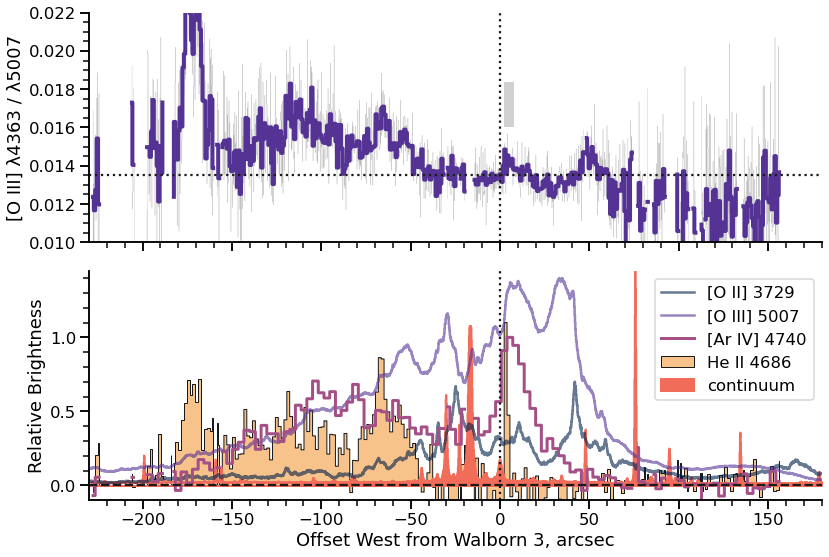

In [18]:
import cmasher as cmr
fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Take 5 colors from rainforest in [0.15, 0.85] range in HEX
#colors = cmr.take_cmap_colors('cmr.rainforest', 5, cmap_range=(0.15, 0.85), return_fmt='hex')
colors = cmr.take_cmap_colors(
    'cmr.torch', 
    5, 
    cmap_range=(0.15, 0.85), 
    return_fmt='hex'
)



# Ratio plot
e1 = emlines["[O III] 4363"]
e2 = emlines["[O III] 5007"]
xmin, xmax = -230, 180

n = 1
ratioA = redcorr_oiii_ratio * e1.multiA[n].data / e2.multiA[n].data
posA = e1.multiA[n].position
axes[0].plot(
    posA, ratioA, 
    linewidth=0.2, color="k", alpha=0.5, 
    drawstyle="steps-mid",
)

n = 4
ratioA = redcorr_oiii_ratio * e1.multiA[n].data / e2.multiA[n].data
posA = e1.multiA[n].position
axes[0].plot(posA, ratioA, linewidth=4.0, alpha=1.0, color=colors[1], drawstyle="steps-mid")

m = (posA > -50) & (posA < xmax)
average_ratioA = np.nanmean(ratioA[m])

#axes[0].axhline(0.0, linestyle="dashed", color="k")
axes[0].axhline(
    average_ratio_mabel,
    linestyle="dotted",
    color="k",
)

axes[0].axvspan(
    2, 8,
    0.5, 0.7,
    linewidth=0.0,
    facecolor="k",
    alpha=0.2,
)

axes[0].axvline(0.0, linestyle="dotted", color="k")
axes[0].set(
    xlim=[xmin, xmax],
    ylim=[0.01, 0.022],
    ylabel="[O III] λ4363 / λ5007",
)



# Profile plot

n = 8
e = emlines["He II 4686"]
fac = 1.1 / np.nanmax(e.multiA[n].data)
axes[1].fill_between(
    e.multiA[n].position,
    fac * e.multiA[n].data,
    linewidth=1.0,
    alpha=1.0,
    color=colors[4],
    edgecolor="k",
    label=e.name,
    step="mid",
)

e = emlines["[O II] 3729"]
fac = 0.7 / np.nanmax(e.A.data)
axes[1].plot(
    e.A.position,
    fac * e.A.data,
    linewidth=2.5,
    alpha=0.6,
    drawstyle="steps-mid",
    color=colors[0],
    label=e.name,
)

e = emlines["[Ne III] 3869"]
e = emlines["[O III] 5007"]
fac = 1.4 / np.nanmax(e.A.data)
axes[1].plot(
    e.A.position,
    fac * e.A.data,
    linewidth=2.5,
    alpha=0.6,
    drawstyle="steps-mid",
    color=colors[1],
    label=e.name,
)


n = 16
e = emlines["[Ar IV] 4740"]
fac = 1.0 / np.nanmax(e.multiA[n].data)
axes[1].plot(
    e.multiA[n].position,
    fac * e.multiA[n].data,
    linewidth=3.0,
    alpha=1.0,
    drawstyle="steps-mid",
    color=colors[2],
    label=e.name,
)

n = 1
fac = 1.45 / np.nanmax(e.multi_cA[n].data)
axes[1].fill_between(
    e.multi_cA[n].position,
    fac * e.multi_cA[n].data,
    linewidth=2.0,
    alpha=1.0,
    color=colors[3],
    label="continuum",
    step="mid",
)


axes[1].axhline(0.0, linestyle="dashed", color="k")
axes[1].axvline(0.0, linestyle="dotted", color="k")

axes[1].set(
    xlim=[xmin, xmax],
    ylim=[-0.1, 1.45],
)
axes[1].legend()
axes[-1].set(
    xlabel="Offset West from Walborn 3, arcsec",
    ylabel="Relative Brightness",
)

for ax in axes:
    ax.minorticks_on()

sns.despine()
fig.tight_layout()
fig.savefig("../figs/ngc346-fors1-combo.pdf")

## Analysis of 4363 / 5007 ratio

In [19]:
import pyneb as pn
o3 = pn.Atom("O", 3)

In [20]:
o3.getTemDen(
    int_ratio=[average_ratio_mabel, 0.0145, 0.016, 0.022],
    den=100.0,
    wave1=4363,
    wave2=5007,
)

array([12841.70649884, 13210.6250713 , 13754.33064909, 15882.78464235])

So that is rather small variation in temperature. including the ratios seen in the SNR sections. 

Define regions to take the nebular BG and the rise at the bow shock rim.

In [28]:
e1 = emlines["[O III] 4363"]
e2 = emlines["[O III] 5007"]

pos_bg = [-6.0, -2.0]
pos_rim = [2.0, 8.0]
mask_bg = (e1.A.position >= pos_bg[0]) &  (e1.A.position <= pos_bg[1])
mask_rim = (e1.A.position >= pos_rim[0]) &  (e1.A.position <= pos_rim[1])
e1_rim_data = e1.A.data[mask_rim]
e2_rim_data = e2.A.data[mask_rim]
e1_bg_data = e1.A.data[mask_bg]
e2_bg_data = e2.A.data[mask_bg]

Do bootstrap resampling to find the uncertainty in the mean values:

In [62]:
from astropy.stats import bootstrap
nboot = 100000
e1_rim_means = bootstrap(e1_rim_data, nboot, bootfunc=np.mean)
print("Standard error of mean: sigma/sqrt(n) = ", e1_rim_data.std() / np.sqrt(len(e1_rim_data)))
print("Standard deviation of bootstrap means: ", e1_rim_means.std())
print("The two numbers should be roughly the same")

Standard error of mean: sigma/sqrt(n) =  4.850779550427951
Standard deviation of bootstrap means:  4.8416554133862
The two numbers should be roughly the same


In [63]:
e2_rim_means = bootstrap(e2_rim_data, nboot, bootfunc=np.mean)
e1_bg_means = bootstrap(e1_bg_data, nboot, bootfunc=np.mean)
e2_bg_means = bootstrap(e2_bg_data, nboot, bootfunc=np.mean)

In [64]:
from astropy import uncertainty as unc

Reserve the bare names `e1_rim`, etc. for the uncertainty distributions

In [65]:
e1_rim = unc.Distribution(e1_rim_means)
e2_rim = unc.Distribution(e2_rim_means)
e1_bg = unc.Distribution(e1_bg_means)
e2_bg = unc.Distribution(e2_bg_means)

R_bg = e1_bg / e2_bg
R_bs = (e1_rim - e1_bg) / (e2_rim - e2_bg)

In [66]:
print(f"BS 4363 / 5007 = {R_bs.pdf_mean():.4f} +/- {R_bs.pdf_std():.4f}")
print(f"BG 4363 / 5007 = {R_bg.pdf_mean():.4f} +/- {R_bg.pdf_std():.4f}")

BS 4363 / 5007 = 0.0166 +/- 0.0015
BG 4363 / 5007 = 0.0126 +/- 0.0002


Calculate ratio for T grid with pyneb, since it is more efficient to use linear interpolation for large numbers of ratios:

In [104]:
Tgrid = np.linspace(5000.0, 30000.0, 251)
Rgrid = o3.getEmissivity(tem=Tgrid, den=100.0, wave=4363) / o3.getEmissivity(tem=Tgrid, den=100.0, wave=5007)

In [105]:
T_bg = unc.Distribution(np.interp(R_bg.distribution, Rgrid, Tgrid))
T_bs = unc.Distribution(np.interp(R_bs.distribution, Rgrid, Tgrid))

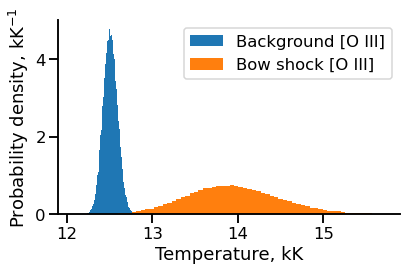

In [162]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.hist(T_bg.distribution / 1000, bins=100, density=True, label="Background [O III]")
ax.hist(T_bs.distribution / 1000, bins=100, density=True, label="Bow shock [O III]")
ax.legend()
ax.set(
    xlabel="Temperature, kK",
    ylabel="Probability density, kK$^{-1}$",
    xlim=[11.9, 15.9],
)
sns.despine()
fig.tight_layout();

In [107]:
from mpdaf.obj import Image

In [108]:
im4740 = Image("../data/ngc346-ariv-4740-correct.fits")
im4711 = Image("../data/ngc346-ariv-4711-correct.fits")
im7263 = Image("../data/ngc346-ariv-7263-correct.fits")
im7171 = Image("../data/ngc346-ariv-7171-correct.fits")

In [249]:
xslice, yslice = slice(230, 300), slice(144, 245)
def boot2dist(im, w, nboot):
    _data = im[yslice, xslice][20:60, 20:30].data.data
    _mask = im[yslice, xslice][20:60, 20:30].data.mask
    _w = w[yslice, xslice].data.data
    #_statfunc = lambda x: np.average(x, weights=_w[~_mask])
    _statfunc = np.mean
    return unc.Distribution(
        bootstrap(_data[~_mask], nboot, bootfunc=_statfunc)
    )

In [250]:
nboot = 10000
weights = im4740 + im4711
i4740 = boot2dist(im4740, weights, nboot)
i4711 = boot2dist(im4711, weights, nboot)
i7263 = boot2dist(im7263, weights, nboot)
i7171 = boot2dist(im7171, weights, nboot)

In [251]:
R1 = i4711 / i4740
R34 = (i7263 + i7171) / (i4711 + i4740)
R3 = i7263 / (i4711 + i4740)
R4 = i7171 / (i4711 + i4740)

In [252]:
print(f"4711 / 4740 = {R1.pdf_mean():.4f} +/- {R1.pdf_std():.4f}")
print(f"7263 / (4711 + 4740) = {R3.pdf_median():.4f} +/- {R3.pdf_std():.4f}")
print(f"7171 / (4711 + 4740) = {R4.pdf_median():.4f} +/- {R4.pdf_std():.4f}")

4711 / 4740 = 1.3676 +/- 0.0199
7263 / (4711 + 4740) = 0.0137 +/- 0.0011
7171 / (4711 + 4740) = 0.0215 +/- 0.0013


In [253]:
ar4 = pn.Atom("Ar", 4)

In [254]:
e4711 = ar4.getEmissivity(tem=Tgrid, den=100.0, wave=4711)
e4740 = ar4.getEmissivity(tem=Tgrid, den=100.0, wave=4740)
e7263 = ar4.getEmissivity(tem=Tgrid, den=100.0, wave=7263)
e7171 = ar4.getEmissivity(tem=Tgrid, den=100.0, wave=7171)
R34grid = (e7263 + e7171) / (e4711 + e4740)
R3grid = e7263 / (e4711 + e4740)
R4grid = e7171 / (e4711 + e4740)

In [255]:
T_R3 = unc.Distribution(np.interp(R3.distribution, R3grid, Tgrid))
T_R4 = unc.Distribution(np.interp(R4.distribution, R4grid, Tgrid))

In [256]:
print(f"T([Ar IV] R3) = {T_R3.pdf_mean():.4f} +/- {T_R3.pdf_std():.4f}")
print(f"T([Ar IV] R4) = {T_R4.pdf_mean():.4f} +/- {T_R4.pdf_std():.4f}")

T([Ar IV] R3) = 15312.1472 +/- 955.5476
T([Ar IV] R4) = 19574.3741 +/- 1188.6034


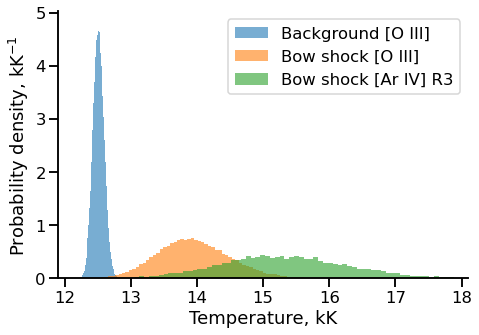

In [263]:
fig, ax = plt.subplots(figsize=(7, 5))
ax.hist(T_bg.distribution / 1000, bins=100, density=True, label="Background [O III]", alpha=0.6)
ax.hist(T_bs.distribution / 1000, bins=100, density=True, label="Bow shock [O III]", alpha=0.6)
ax.hist(T_R3.distribution / 1000, bins=100, density=True, label="Bow shock [Ar IV] R3", alpha=0.6)
#ax.hist(T_R4.distribution / 1000, bins=100, density=True, label="Bow shock [Ar IV] R4", alpha=0.6)
ax.legend()
ax.set(
    xlabel="Temperature, kK",
    ylabel="Probability density, kK$^{-1}$",
    xlim=[11.9, 18.1],
)
sns.despine()
fig.tight_layout()
fig.savefig("../figs/ngc346-bowshock-T-oiii-ariv.pdf");

In [258]:
dengrid = np.linspace(1.0, 5000.0, 1000)[::-1]
e4711d = ar4.getEmissivity(tem=14500, den=dengrid, wave=4711)
e4740d = ar4.getEmissivity(tem=14500, den=dengrid, wave=4740)
R1grid = e4711d / e4740d


In [259]:
den_R1 = unc.Distribution(np.interp(R1.distribution, R1grid, dengrid))

In [260]:
R1

NdarrayDistribution([1.37759962, 1.3389781 , 1.37659629, ..., 1.31868134, 1.35776608,
       1.36088439]) with n_samples=10000

In [261]:
print(f"n_e([Ar IV] R1) = {den_R1.pdf_mean():.4f} +/- {den_R1.pdf_std():.4f}")


n_e([Ar IV] R1) = 152.8346 +/- 119.2694


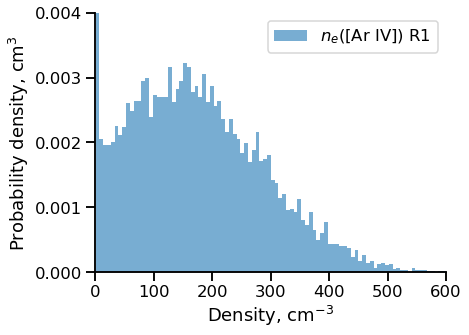

In [266]:
fig, ax = plt.subplots(figsize=(7, 5))
ax.hist(den_R1.distribution, bins=100, density=True, label="$n_e$([Ar IV]) R1", alpha=0.6)
#ax.hist(T_R4.distribution / 1000, bins=100, density=True, label="Bow shock [Ar IV] R4")
ax.legend()
ax.set(
    xlabel="Density, cm$^{-3}$",
    ylabel="Probability density, cm$^{3}$",
    xlim=[0.0, 600.0],
    ylim=[0.0, 0.004],
)
sns.despine()
fig.tight_layout()
fig.savefig("../figs/ngc346-bowshock-den-ariv.pdf");

In [228]:
R1

NdarrayDistribution([1.32362349, 1.32232221, 1.33200633, ..., 1.32236316, 1.33683764,
       1.32159105]) with n_samples=10000

/Users/will/miniconda3/envs/py39/lib/python3.9/site-packages/mpdaf/obj/arithmetic.py:124: RuntimeWarning: invalid value encountered in true_divide
  var /= (b_data ** 4)


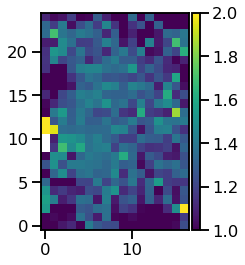

In [229]:
(im4711[yslice, xslice].rebin(4) / im4740[yslice, xslice].rebin(4)).plot(vmin=1.0, vmax=2.0, colorbar="v")

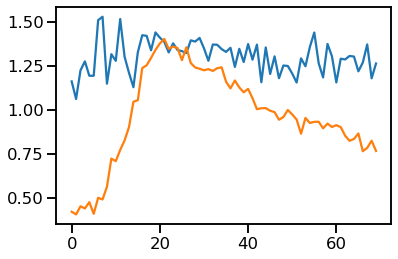

In [248]:
win4711 = im4711[yslice, xslice]
win4740 = im4740[yslice, xslice]

prof4711 = np.mean(win4711.data[20:60, :], axis=0)
prof4740 = np.mean(win4740.data[20:60, :], axis=0)
fig, ax = plt.subplots()

ax.plot(prof4711 / prof4740)
ax.plot((prof4711 + prof4740) / 400)

## More graphs

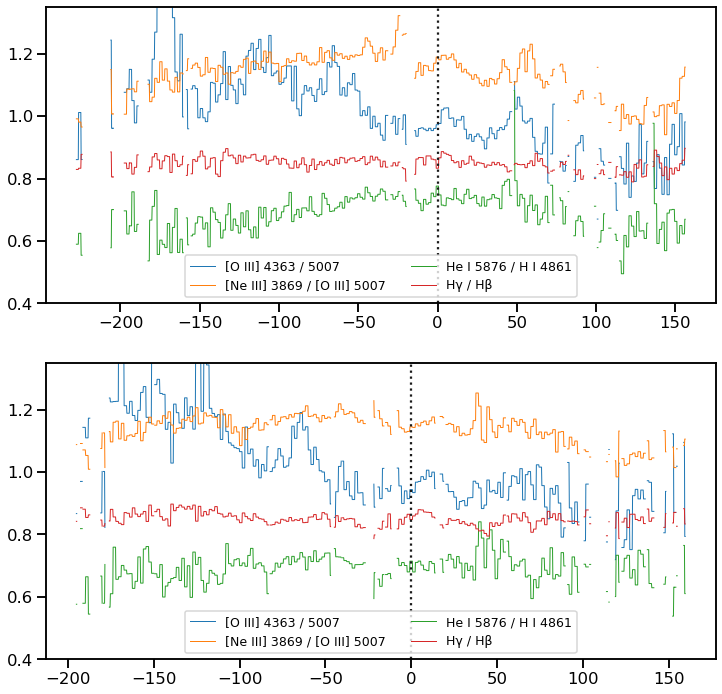

In [22]:
fig, axes = plt.subplots(2, 1, figsize=(12, 12))
n = 8
sA = {e.name: e.multiA[n].data for e in emlines.values()}
e = emlines["[O III] 5007"]
posA = e.multiA[n].position
sB = {e.name: e.multiB[n].data for e in emlines.values()}
e = emlines["[O III] 5007"]
posB = e.multiB[n].position

for ax, pos, s in zip(axes, [posA, posB], [sA, sB]):
    ax.plot(
        pos,
        s["[O III] 4363"]
        / s["[O III] 5007"]
        / np.nanmedian(s["[O III] 4363"] / s["[O III] 5007"]),
        linewidth=1.0,
        alpha=1.0,
        label="[O III] 4363 / 5007",
    )
    ax.plot(
        pos,
        0.15 + s["[Ne III] 3869"]
        / s["[O III] 5007"]
        / np.nanmedian(s["[Ne III] 3869"] / s["[O III] 5007"]),
        linewidth=1.0,
        alpha=1.0,
        label="[Ne III] 3869 / [O III] 5007",
    )
    ax.plot(
        pos,
        -0.3 + + s["He I 5876"] / s["H I 4861"] / np.nanmedian(s["He I 5876"] / s["H I 4861"]),
        #    0.1* s4341 / np.median(s4341),
        linewidth=1.0,
        alpha=1.0,
        label="He I 5876 / H I 4861",
    )
    ax.plot(
        pos,
        -0.15 + s["H I 4340"] / s["H I 4861"] / np.nanmedian(s["H I 4340"] / s["H I 4861"]),
        linewidth=1.0,
        alpha=1.0,
        label="Hγ / Hβ",
    )
    # ax.plot(positions, 0.0003 * s4686, linewidth=2.0, alpha=1.0)
    ax.axhline(0.0, linestyle="dashed", color="k")
    ax.axvline(0.0, linestyle="dotted", color="k")

    ax.legend(fontsize="x-small", ncol=2)
    ax.set(
        # xlim=[-10, 50],
        # xlim=[-230, 200],
        ylim=[0.4, 1.35],
    )

In [23]:
posA[np.isfinite(posA)]

array([ 156.2,  156. ,  155.8, ..., -227.4, -227.6, -227.8])

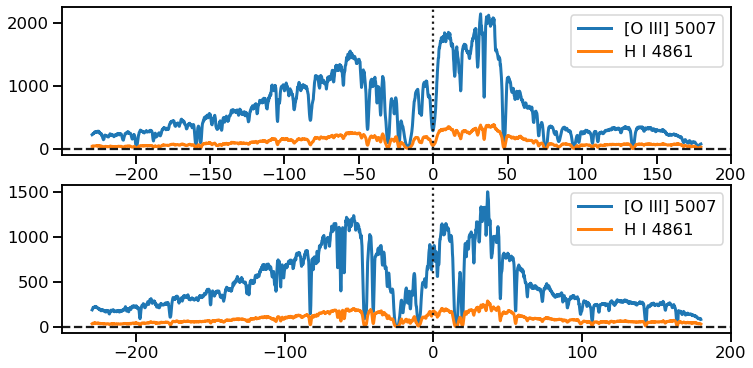

In [24]:
fig, axes = plt.subplots(2, 1, figsize=(12, 6))
for ax, ew in zip(axes, ["ewA", "ewB"]):
    for line in "[O III] 5007", "H I 4861":
        p = getattr(emlines[line], ew)
        ax.plot(p.position, p.data, linewidth=3.0, alpha=1.0, label=line)
    ax.axhline(0.0, linestyle="dashed", color="k")
    ax.axvline(0.0, linestyle="dotted", color="k")
    ax.legend()
    ax.set(
        # xlim=[-10, 50],
        # ylim=[-0.003, 0.02],
    )

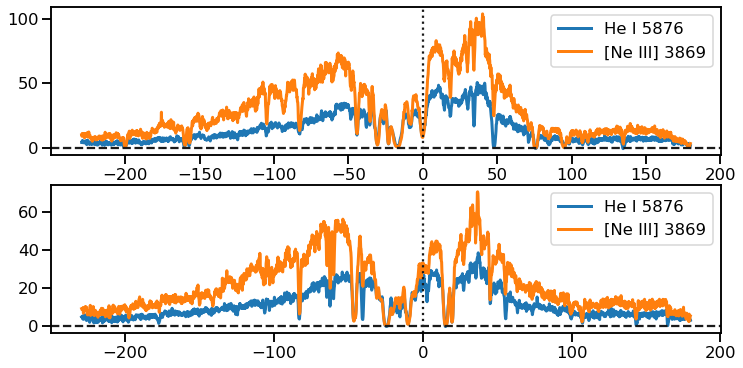

In [25]:
fig, axes = plt.subplots(2, 1, figsize=(12, 6))
for ax, ew in zip(axes, ["ewA", "ewB"]):
    for line in "He I 5876", "[Ne III] 3869":
        p = getattr(emlines[line], ew)
        ax.plot(p.position, p.data, linewidth=3.0, alpha=1.0, label=line)
    ax.axhline(0.0, linestyle="dashed", color="k")
    ax.axvline(0.0, linestyle="dotted", color="k")
    ax.legend()
    ax.set(
        # xlim=[-10, 50],
        # ylim=[-0.003, 0.02],
    )

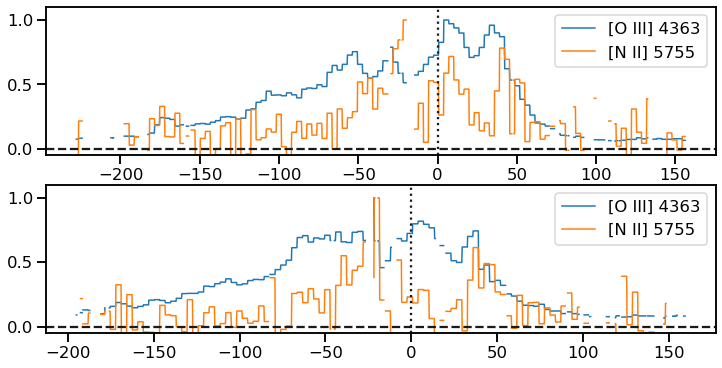

In [26]:
fig, axes = plt.subplots(2, 1, figsize=(12, 6))
n = 16
for ax, multi in zip(axes, ["multiA", "multiB"]):
    for line in "[O III] 4363", "[N II] 5755":
        p = getattr(emlines[line], multi)[n]
        ax.plot(
            p.position, p.data / np.nanmax(p.data), linewidth=1.5, alpha=1.0, label=line
        )
    ax.axhline(0.0, linestyle="dashed", color="k")
    ax.axvline(0.0, linestyle="dotted", color="k")
    ax.legend()
    ax.set(
        # xlim=[-10, 50],
        ylim=[-0.05, 1.1],
    )

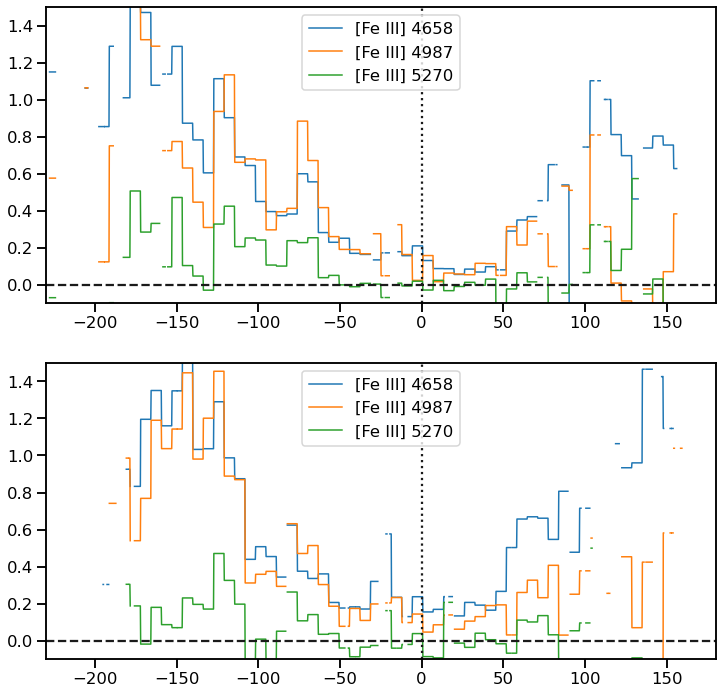

In [27]:
fig, axes = plt.subplots(2, 1, figsize=(12, 12))
n = 32
for ax, multi in zip(axes, ["multiA", "multiB"]):
    for line in "[Fe III] 4658", "[Fe III] 4987", "[Fe III] 5270":
        p = getattr(emlines[line], multi)[n]
        scale = 100 / getattr(emlines["H I 4861"], multi)[n].data
        if "4987" in line:
            correct = getattr(emlines["Wing 4975"], multi)[n].data
        else:
            correct = 0.0
        ax.plot(
            p.position, scale * (p.data - correct), linewidth=1.5, alpha=1.0, label=line
        )
    ax.axhline(0.0, linestyle="dashed", color="k")
    ax.axvline(0.0, linestyle="dotted", color="k")
    ax.legend()
    ax.set(
        #        xlim=[-100, 50],
        xlim=[xmin, xmax],
        ylim=[-0.1, 1.5],
    )